This notebook incorporates the WhiteNoise kernel to produce error bar charts and parity plots per round. This is based on helpful discussions with Jaron Thompson on 8-01-24.

# Header Material

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as ss

from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.model_selection import train_test_split, KFold,LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
from src.models.constants import Constants
from src.models import util
from src.models.gaussian_process import featurize

In [4]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
raw_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Thru Rnd 1",3:"Thru Rnd 2",4:"Thru Rnd 3",5:"Thru Rnd 4",6:"Thru Rnd 5",7:"Thru Rnd 6-GP"}
seed=0
df2 = pd.read_csv(processed_dir+"/"+"2-cleanedup_Round8-Standardized.csv")
df3 = pd.read_csv(processed_dir+"/"+"2-cleanedup_Round8-Standardized.csv")
print(df2.shape)
df3.head()

(140, 20)


,Unnamed: 0,Catalyst,Reaction,Tube,Date,Mass Catalyst,Mass Diluent,k_d,Y0,lifetime_yield,Y_pc,sqrtY0Y_pc,Pt,Sn,Ga,Fe,Cu,Ca,Mn,Zn
0,0,Pt1/γ-Al2O3 2/5/24,24-005,1,2024-02-05,20.0,120.2,0.011951,0.093141,7.793377,7.350753,0.827439,1,0.0,0.0,0.0,0.0,0.0,0,0
1,1,Pt1/γ-Al2O3 2/5/24,24-005,2,2024-02-05,20.1,120.0,0.011695,0.138308,11.826379,11.112063,1.239711,1,0.0,0.0,0.0,0.0,0.0,0,0
2,2,Pt1/γ-Al2O3 2/5/24,24-005,3,2024-02-05,20.0,120.0,0.010522,0.063163,6.002886,5.522449,0.590604,1,0.0,0.0,0.0,0.0,0.0,0,0
3,3,Pt1/γ-Al2O3 2/5/24,24-005,4,2024-02-05,20.0,120.0,0.009353,0.055320,5.915015,5.288208,0.540875,1,0.0,0.0,0.0,0.0,0.0,0,0
4,4,Pt1/γ-Al2O3 2/5/24,24-005,5,2024-02-05,20.1,120.2,0.009263,0.062064,6.700162,5.974731,0.608945,1,0.0,0.0,0.0,0.0,0.0,0,0


In [5]:
Sets = {"Training":["005","006","007","008","009","010","011","015","016"],
        "Round 1":["005","006","007","008","009","010","011","015","016","023"],
       "Round 2":["005","006","007","008","009","010","011","015","016","023","025"],
       "Round 3":["005","006","007","008","009","010","011","015","016","023","025","030"],
       "Round 4":["005","006","007","008","009","010","011","015","016","023","025","030","031"],
        "Round 5 GP":["005","006","007","008","009","010","011","015","016","023","025","030","031","034"],
        "Round 6 GP":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","038"],
        "Round 5 KNN":["005","006","007","008","009","010","011","015","016","023","025","030","031","035"],
        "Round 6 KNN":["005","006","007","008","009","010","011","015","016","023","025","030","031","035","049"],
        "Pre-Round 7":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049","050","051","052","053","054","055","056","058","061"],
        "Round 7":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049","050","051","052","053","054","055","056","058","061","064"]}


# Rounds 5-6 (Fine Grid) Bar Chart and Parity Plots LOO-CV

In [40]:
df3['Reaction'] = df3['Reaction'].str.replace('24-','')

header=["Sn","Ga","Fe","Cu","Ca","diversity","loading"]
res = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{},"r2_train":{},"rmse_train":{},"mae_train":{}}
vals = {}
for name in ["Round 4","Round 5 GP","Round 6 GP","Round 5 KNN","Round 6 KNN"]:
    rxns = Sets[name]
    df_sel = df3[df3["Reaction"].isin(rxns)]
    print(f'{name}: {df_sel.shape[0]} data points pre-averaging')
    df_sel = df_sel.copy()
    cols_to_preserve = Constants().METRICS
    df_sel["idx"] = [i for i in range(df_sel.shape[0])]
    cols_to_preserve.append("idx")
    df_sel = df_sel.groupby(Constants().ALL_TESTED_METALS)[cols_to_preserve].mean().reset_index()
    print(f'{name}: {df_sel.shape[0]} data points post-averaging')
    df_sel["diversity"] = df_sel[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
    df_sel["loading"] = df_sel[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)
    df_sel=df_sel.sort_values("idx")
    
    X = df_sel[header].to_numpy()
    y = df_sel["sqrtY0Y_pc"].to_numpy()
#     Y_pc = -df_sel['Y0']/df_sel['k_d'] * (np.exp(-df_sel['k_d']*240)-np.exp(-df_sel['k_d']*0))
#     y = np.sqrt(df_sel['Y0']*Y_pc).to_numpy()
    print(name,rxns,X.shape)
    n = X.shape[0]
    
    y_preds = []
    y_stds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
#         X_train,y_train = remove_duplicates(X_train,X_test,y_train,y_test) #avoid leakage by removing identical entries
        kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))
    
        pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
        pipeline.fit(X_train,y_train)
        y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
        y_preds.append(y_pred[0])
        y_stds.append(y_pred_std[0])
        y_actuals.append(y_test[0])        
        
#         y_train = np.hstack((y_train.reshape(-1,1),np.zeros(y_train.shape[0]).reshape(-1,1))) #add an extra col of 0s
#         mu,sigma = util.GP_regressor(X_train,y_train,X_test,verbose=False)
#         y_preds.append(mu[0])
#         y_stds.append(sigma[0])
#         y_actuals.append(y_test[0])

    pred = np.asarray(y_preds)
    expt = np.asarray(y_actuals)
    vals[name] = {"pred":pred,"expt":expt,"idxs":list(df_sel["idx"])}



    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} MAE {mae:.3} RMSE {rmse:.3} R2: {r2:.3}'
    res["rmse"][name]=rmse
    res["r2"][name]=r2
    res["mae_norm"][name]=mae_norm
    res["mae"][name]=mae
    res["rmse_norm"][name]=rmse_norm
    print(label)
    print(expt[0:6])
    print(pred[0:6])
    print(y_stds[0:6])
    #r2 on training dataset
    pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
    pipeline.fit(X,y)
    y_pred,y_pred_std = pipeline.predict(X,return_std=True)
    slope, intercept, r_value, p_value, std_err = ss.linregress(y,y_pred)
    r2_train = r_value**2
    mae_train = np.mean(np.abs(y_pred-y))
    rmse_train = np.sqrt(mean_squared_error(y,y_pred))
    res["r2_train"][name]=r2_train
    res["mae_train"][name]=mae_train
    res["rmse_train"][name]=rmse_train
    print(y_pred[0:6])
    print(y_pred_std[0:6])
    

Round 4: 64 data points pre-averaging
Round 4: 50 data points post-averaging
Round 4 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031'] (50, 7)
Round 4 MAE 0.754 RMSE 0.916 R2: 0.494
[0.74942977 4.8395896  4.70969799 3.66934212 4.01627931 0.8051922 ]
[2.14383064 4.29037829 3.53883796 2.22105601 3.35020126 2.41450226]
[0.5977110711045246, 0.8351928695974677, 0.8648245121369382, 1.725446927321278, 1.4925091298907884, 1.9043218223277367]
[0.74942977 4.8395896  4.70969799 3.66934212 4.01627931 0.8051922 ]
[9.99995600e-06 9.99991160e-06 1.00000004e-05 1.00000004e-05
 1.00000004e-05 9.99995600e-06]
Round 5 GP: 70 data points pre-averaging
Round 5 GP: 56 data points post-averaging
Round 5 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034'] (56, 7)
Round 5 GP MAE 0.735 RMSE 0.925 R2: 0.474
[0.74942977 4.8395896  4.70969799 3.66934212 4.01627931 0.8051922 ]
[2.1834972  3.52682852 3.42036047 1.82562696 2.3

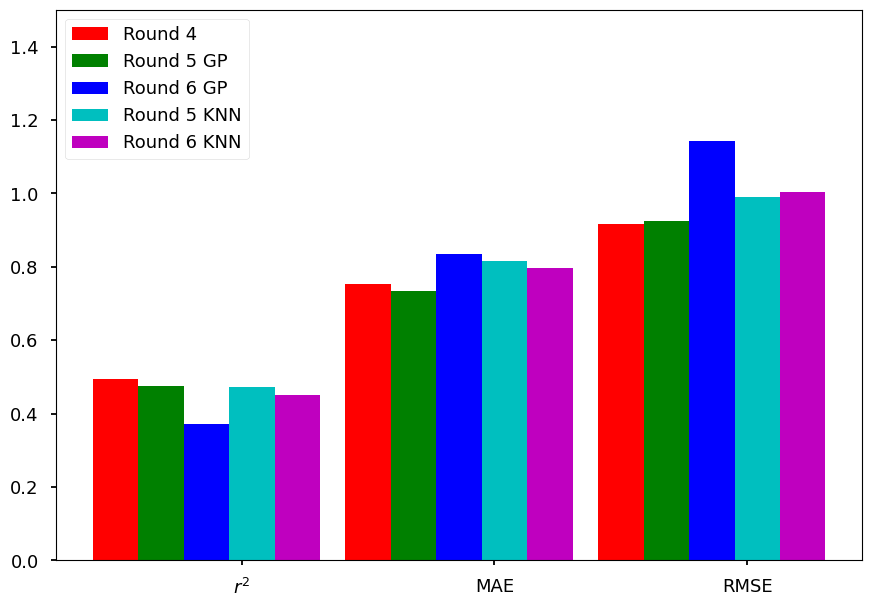

In [10]:
width =.9/len(vals.keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res['r2'].keys() #names of various rounds
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,["$r^2$","MAE","RMSE"])
plt.legend(loc='upper left')
plt.ylim((0,1.5))

#plt.savefig('./manuscript_figures/bar-chart-coarse-grid-all-data.png',dpi=600,bbox_inches='tight')
plt.show()

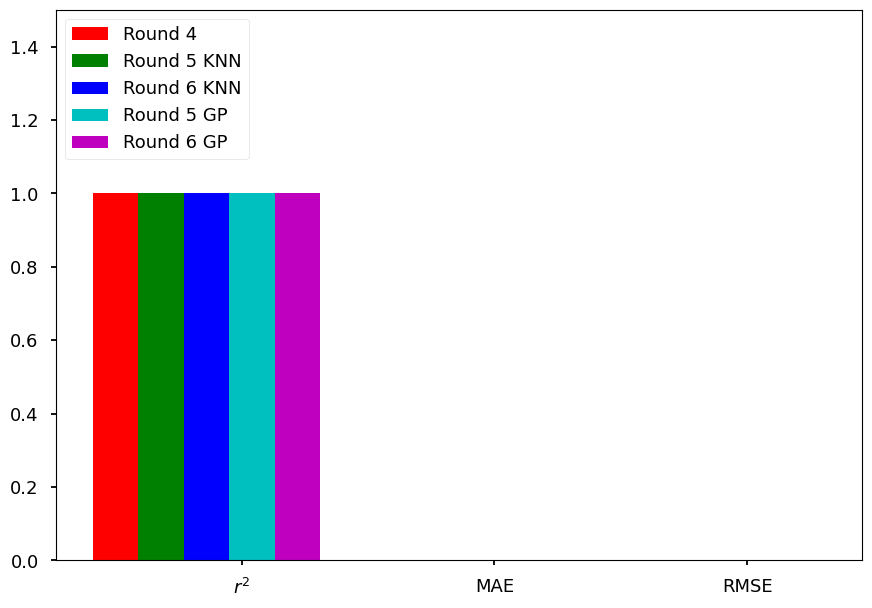

In [18]:
#performance on training dataset
width =.9/len(vals.keys())
scores = {"r2_train":0,"mae_train":1,"rmse_train":2}
names = res['r2'].keys() #names of various rounds
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(scores.keys()):
    for j,name in enumerate(names):
        if val == 'r2_train':
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,["$r^2$","MAE","RMSE"])
plt.legend(loc='upper left')
plt.ylim((0,1.5))

#plt.savefig('./manuscript_figures/bar-chart-coarse-grid-all-data.png',dpi=600,bbox_inches='tight')
plt.show()

In [105]:
vals.keys()

dict_keys(['Training', 'Round 1', 'Round 2', 'Round 3', 'Round 4'])

In [44]:
#Getting metrics for first 26 catalysts only
vals_26 = {}
res_26 = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{}}
for k,v in vals.items():
    name=k
    vals_26[k] = {}
    for k2,v2 in v.items():
        vals_26[k][k2] = v2[0:26] #select first 26
    pred = vals_26[k]["pred"]
    expt = vals_26[k]["expt"]
    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} MAE {mae:.3} RMSE {rmse:.3} R2: {r2:.3}'
    res_26["rmse"][name]=rmse
    res_26["r2"][name]=r2
    res_26["mae_norm"][name]=mae_norm
    res_26["mae"][name]=mae
    res_26["rmse_norm"][name]=rmse_norm
    
    


width =.9/len(vals_26.keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res_26['r2'].keys() #names of various rounds
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res_26[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res_26[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,["$r^2$","MAE","RMSE"])
plt.legend(loc='upper left')
plt.ylim((0,1.75))
plt.show()
plt.savefig('./manuscript_figures/bar-chart-fine-grid-26-cat-holdout.png',dpi=600,bbox_inches='tight')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [81]:
df_res.head()


,pred,expt,idxs
0,1.135392,0.749430,6.142857
34,3.755681,4.839590,10.000000
37,2.652587,4.709698,15.000000
46,2.219963,3.669342,16.000000
43,1.140116,4.016279,17.000000


In [33]:
vals

{'Round 4': {'pred': array([2.14383064, 4.29037829, 3.53883796, 2.22105601, 3.35020126,
         2.41450226, 0.98399456, 1.76164715, 3.91153809, 2.73121405,
         2.29724336, 2.45015994, 1.10171788, 1.62229906, 2.6006081 ,
         4.44078711, 2.75819245, 2.8277678 , 2.38874079, 0.99684476,
         0.73410085, 1.57203256, 2.09879132, 2.78773645, 0.10624323,
         2.57114043, 3.99192675, 4.70111531, 3.84378853, 2.57347141,
         3.77225253, 4.16901777, 4.93715389, 4.20041475, 4.09534751,
         3.78002166, 3.46535256, 2.96731638, 3.64139581, 2.34331419,
         3.96135146, 3.89513429, 3.2497852 , 2.38417898, 4.01323248,
         4.57607367, 4.23208252, 3.86242959, 3.77312119, 3.88397115]),
  'expt': array([0.74942977, 4.8395896 , 4.70969799, 3.66934212, 4.01627931,
         0.8051922 , 1.36202484, 2.2248662 , 3.56008592, 1.63501655,
         2.70617226, 0.57783525, 2.43348475, 1.78185516, 3.08290185,
         4.70779402, 4.01732524, 4.25311089, 1.88052685, 2.50035532,
     

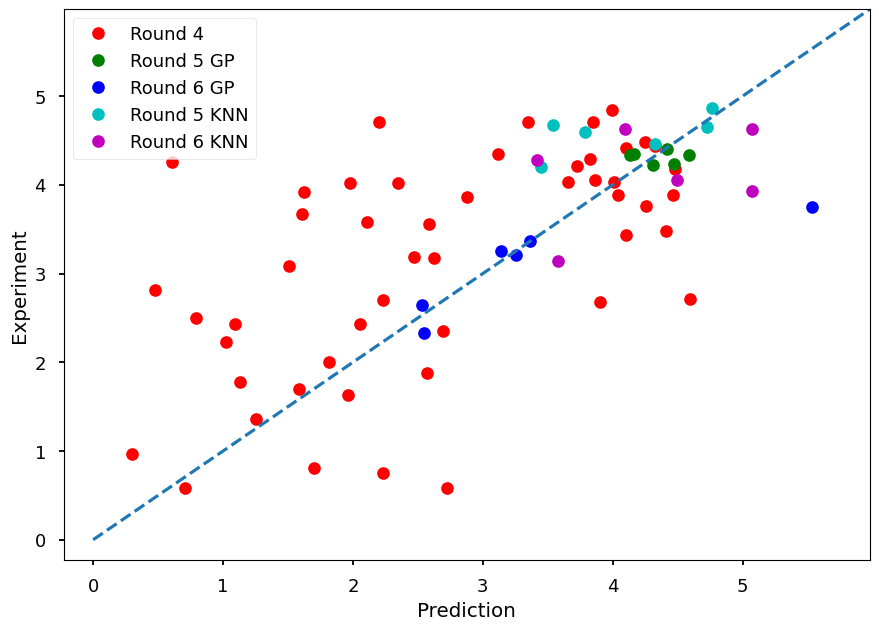

In [42]:
res_parity_plot = {}
 
for i,(k,v) in enumerate(vals.items()):
    v["idxs"] = list(v["idxs"])
    v["expt"] = list(v["expt"])
    v["pred"] = list(v["pred"])
    if k == "Round 6 GP":
        low = 0
        high = 50
        res_parity_plot["Round 4"] = {'pred':v['pred'][low:high],'expt':v['expt'][low:high],'idxs':v['idxs'][low:high]}
        plt.plot(v['pred'][low:high], v['expt'][low:high], 'o',color=color_list[0],label="Round 4")  
        low = 50
        high = 56
        res_parity_plot["Round 5 GP"] = {'pred':v['pred'][low:high],'expt':v['expt'][low:high],'idxs':v['idxs'][low:high]}
        plt.plot(v['pred'][low:high], v['expt'][low:high], 'o',color=color_list[1],label="Round 5 GP")  
        
        low = 56
        high = 62
        res_parity_plot["Round 6 GP"] = {'pred':v['pred'][low:high],'expt':v['expt'][low:high],'idxs':v['idxs'][low:high]}
        plt.plot(v['pred'][low:high], v['expt'][low:high], 'o',color=color_list[2],label="Round 6 GP")  

    elif k == "Round 6 KNN":
        low = 50
        high = 56
        res_parity_plot["Round 5 KNN"] = {'pred':v['pred'][low:high],'expt':v['expt'][low:high],'idxs':v['idxs'][low:high]}
        plt.plot(v['pred'][low:high], v['expt'][low:high], 'o',color=color_list[3],label="Round 5 KNN")  
        
        low = 56
        high = 62
        res_parity_plot["Round 6 KNN"] = {'pred':v['pred'][low:high],'expt':v['expt'][low:high],'idxs':v['idxs'][low:high]}
        plt.plot(v['pred'][low:high], v['expt'][low:high], 'o',color=color_list[4],label="Round 6 KNN")  

plt.plot([0,6],[0,6],'--')
plt.xlabel("Prediction")
plt.ylabel("Experiment")
plt.xlim((min(pred)-.5,max(pred)+.5))
plt.ylim((min(pred)-.5,max(pred)+.5))
plt.legend()
# plt.title(name)
plt.show()
#plt.savefig('./manuscript_figures/parity-plot-coarse-grid-all-data.png',dpi=600,bbox_inches='tight')

In [43]:
#df_res.to_csv('./manuscript_figures/coarse-grid-parity-plot-data.csv')
# Source: https://stackoverflow.com/questions/12309269/how-do-i-write-json-data-to-a-file
import json
with open('./manuscript_figures/fine-grid-all-data.json', 'w', encoding='utf-8') as f:
    json.dump(res, f, ensure_ascii=False, indent=4)
with open('./manuscript_figures/fine-grid-26-cat-holdout-data.json', 'w', encoding='utf-8') as f:
    json.dump(res_26, f, ensure_ascii=False, indent=4)
with open('./manuscript_figures/fine-grid-parity-plot-data.json', 'w', encoding='utf-8') as f:
    json.dump(res_parity_plot, f, ensure_ascii=False, indent=4)

# Rounds 5-6 (Fine Grid) Bar Chart and Parity Plots Round-by-Round

In [22]:
df3['Reaction'] = df3['Reaction'].str.replace('24-','')

header=["Sn","Ga","Fe","Cu","Ca","diversity","loading"]
res = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{},"r2_train":{},"rmse_train":{},"mae_train":{}}
vals = {}

for name in ["Round 5 KNN","Round 6 KNN","Round 5 GP","Round 6 GP"]:
    rxns = Sets[name]
    df_sel = df3[df3["Reaction"].isin(rxns)]
    print(f'{name}: {df_sel.shape[0]} data points pre-averaging')
    df_sel = df_sel.copy()
    cols_to_preserve = Constants().METRICS
    df_sel["idx"] = [i for i in range(df_sel.shape[0])]
    cols_to_preserve.append("idx")
    df_sel = df_sel.groupby(Constants().ALL_TESTED_METALS)[cols_to_preserve].mean().reset_index()
    print(f'{name}: {df_sel.shape[0]} data points post-averaging')
    df_sel["diversity"] = df_sel[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
    df_sel["loading"] = df_sel[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)
    df_sel=df_sel.sort_values("idx")
    
    X = df_sel[header].to_numpy()
    y = df_sel["sqrtY0Y_pc"].to_numpy()
    X_train = X[0:-6,:]
    X_test = X[-6:,:]
    y_train = y[0:-6]
    y_test = y[-6:]

#     Y_pc = -df_sel['Y0']/df_sel['k_d'] * (np.exp(-df_sel['k_d']*240)-np.exp(-df_sel['k_d']*0))
#     y = np.sqrt(df_sel['Y0']*Y_pc).to_numpy()
    print(name,rxns,X.shape)
    n = X.shape[0]

    kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))
    
    pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
    pipeline.fit(X_train,y_train)
    y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)     

    pred = np.asarray(y_pred)
    expt = np.asarray(y_test)
    vals[name] = {"pred":pred,"expt":expt,"idxs":list(df_sel["idx"])}



    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} MAE {mae:.3} RMSE {rmse:.3} R2: {r2:.3}'
    res["rmse"][name]=rmse
    res["r2"][name]=r2
    res["mae_norm"][name]=mae_norm
    res["mae"][name]=mae
    res["rmse_norm"][name]=rmse_norm
    print(label)
    print(expt[0:6])
    print(pred[0:6])
    print(y_stds[0:6])
    #r2 on training dataset
    pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
    pipeline.fit(X,y)
    y_pred,y_pred_std = pipeline.predict(X,return_std=True)
    slope, intercept, r_value, p_value, std_err = ss.linregress(y,y_pred)
    r2_train = r_value**2
    mae_train = np.mean(np.abs(y_pred-y))
    rmse_train = np.sqrt(mean_squared_error(y,y_pred))
    res["r2_train"][name]=r2_train
    res["mae_train"][name]=mae_train
    res["rmse_train"][name]=rmse_train
    print(y_pred[0:6])
    print(y_pred_std[0:6])
    

Round 5 KNN: 70 data points pre-averaging
Round 5 KNN: 56 data points post-averaging
Round 5 KNN ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '035'] (56, 7)
Round 5 KNN MAE 2.06 RMSE 2.45 R2: 0.531
[4.67003392 4.45844267 4.86804071 4.65573298 4.19557717 4.59863791]
[3.28395718 1.7281337  4.36898754 1.48911487 0.17831442 5.17484053]
[0.9518468977862148, 0.6009457948387256, 1.3185641105590775, 2.1281441287639287, 1.534185001637594, 2.302936048450096]
[0.74942977 4.8395896  4.70969799 3.66934212 4.01627931 0.8051922 ]
[9.99995600e-06 9.99995600e-06 1.00000892e-05 1.00000004e-05
 1.00000004e-05 9.99995600e-06]
Round 6 KNN: 76 data points pre-averaging
Round 6 KNN: 62 data points post-averaging
Round 6 KNN ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '035', '049'] (62, 7)
Round 6 KNN MAE 0.645 RMSE 0.769 R2: 0.501
[4.63155404 3.14309401 4.6248845  4.2790342  3.93312121 4.05469046]
[4.67444924 2.328

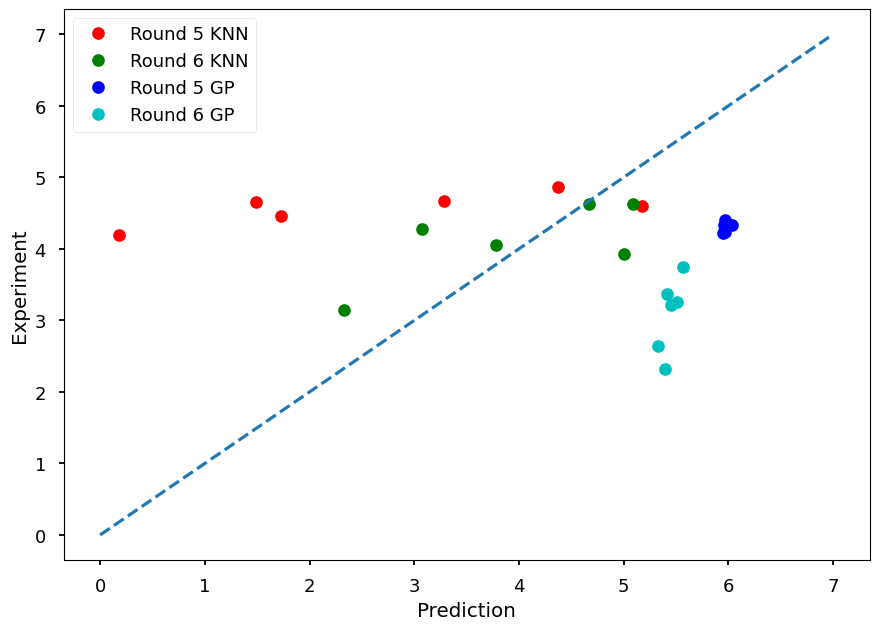

In [25]:
for i,(k,v) in enumerate(vals.items()):
    plt.plot(v['pred'], v['expt'], 'o',color=color_list[i],label=k)

low = 0
high = 7
plt.plot([low,high],[low,high],'--')
plt.xlabel("Prediction")
plt.ylabel("Experiment")
plt.legend()
# plt.title(name)
plt.show()
#plt.savefig('./manuscript_figures/parity-plot-coarse-grid-all-data.png',dpi=600,bbox_inches='tight')